<div style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">
  <h1>sketch2clipart</h1>
    Generate clipart from simple sketches.   
    Data comes from the <a href="https://www.kaggle.com/datasets/vishesh1211/clipart?resource=download-directory" target="_blank">Kaggle Clipart Dataset</a>. 
</div>

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Imports and Functions</h1>
</div>

In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
# View image function
def view_image(image_path):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Dataset
class Sketch2ClipartDataset(Dataset):
    def __init__(self, sketch_dir, clipart_dir, transform=None):
        self.sketch_dir = sketch_dir
        self.clipart_dir = clipart_dir
        self.files = [f for f in os.listdir(sketch_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.files[idx])
        
        # Extract numeric part
        numeric_part = os.path.splitext(self.files[idx])[0].replace("sketch", "")
        clipart_filename = f"clipart{numeric_part}.jpg"
        clipart_path = os.path.join(self.clipart_dir, clipart_filename)
        
        sketch = Image.open(sketch_path).convert("RGB")
        clipart = Image.open(clipart_path).convert("RGB")
        
        if self.transform:
            sketch = self.transform(sketch)
            clipart = self.transform(clipart)
        
        return sketch, clipart


<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Data Preprocessing</h1>
</div>

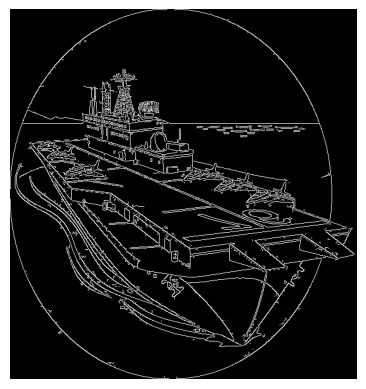

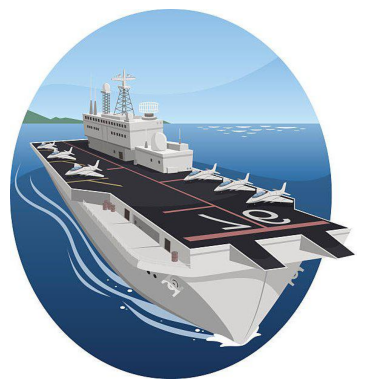

In [3]:
view_image("data/sketch/sketch1.png")
view_image("data/clipart/clipart1.jpg")

In [4]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = Sketch2ClipartDataset("data/sketch", "data/clipart", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
print(f"Dataset size: {len(dataset)} images")

Dataset size: 48833 images


<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Model Implementation</h1>
</div>

In [5]:
# Generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        self.down1 = self.conv_block(in_channels, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        
        self.up1 = self.up_conv_block(512, 256)
        self.up2 = self.up_conv_block(512, 128)
        self.up3 = self.up_conv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)
        self.tanh = nn.Tanh()
    
    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    
    def up_conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        
        u1 = self.up1(d4)
        u1 = torch.cat([u1, d3], dim=1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], dim=1)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], dim=1)
        out = self.final(u3)
        return self.tanh(out)

# Discriminator
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=6):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1),
            nn.Sigmoid()
        )
    
    def forward(self, sketch, clipart):
        x = torch.cat([sketch, clipart], dim=1)
        return self.model(x)

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Methods</h1>
</div>

In [6]:
# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = UNetGenerator().to(device)
discriminator = PatchDiscriminator().to(device)

# Losses and optimizers
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
num_epochs = 5
g_losses = []
d_losses = []

for epoch in tqdm(range(num_epochs)):
    for i, (sketch, clipart) in enumerate(dataloader):
        sketch = sketch.to(device)
        clipart = clipart.to(device)
        generated_clipart = generator(sketch)
        generated_clipart = nn.functional.interpolate(
            generated_clipart, size=(256, 256), mode='bilinear', align_corners=False
        )
        d_output = discriminator(sketch, generated_clipart)

        # Make target tensors match discriminator output size
        valid = torch.ones_like(d_output).to(device)
        fake = torch.zeros_like(d_output).to(device)

        g_adv_loss = adversarial_loss(d_output, valid)

        g_l1_loss = l1_loss(generated_clipart, clipart)
        g_loss = g_adv_loss + 100 * g_l1_loss
        g_loss.backward()
        g_optimizer.step()

        # Discriminator
        d_optimizer.zero_grad()
        real_output = discriminator(sketch, clipart)
        fake_output = discriminator(sketch, generated_clipart.detach())
        d_real_loss = adversarial_loss(real_output, valid)
        d_fake_loss = adversarial_loss(fake_output, fake)
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")


  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 0/5] [Batch 0] [D loss: 0.7186] [G loss: 76.4784]
[Epoch 0/5] [Batch 100] [D loss: 0.0305] [G loss: 58.8014]
[Epoch 0/5] [Batch 200] [D loss: 0.0738] [G loss: 38.0323]
[Epoch 0/5] [Batch 300] [D loss: 0.0085] [G loss: 60.4720]
[Epoch 0/5] [Batch 400] [D loss: 0.0231] [G loss: 63.8000]
[Epoch 0/5] [Batch 500] [D loss: 0.0060] [G loss: 73.6623]
[Epoch 0/5] [Batch 600] [D loss: 0.0113] [G loss: 54.7920]
[Epoch 0/5] [Batch 700] [D loss: 0.0028] [G loss: 79.1109]
[Epoch 0/5] [Batch 800] [D loss: 0.0043] [G loss: 54.2124]
[Epoch 0/5] [Batch 900] [D loss: 0.0016] [G loss: 85.3775]
[Epoch 0/5] [Batch 1000] [D loss: 0.0023] [G loss: 58.3889]
[Epoch 0/5] [Batch 1100] [D loss: 0.0031] [G loss: 67.4604]
[Epoch 0/5] [Batch 1200] [D loss: 0.0023] [G loss: 46.6909]
[Epoch 0/5] [Batch 1300] [D loss: 0.0019] [G loss: 60.0354]
[Epoch 0/5] [Batch 1400] [D loss: 0.0016] [G loss: 60.5557]
[Epoch 0/5] [Batch 1500] [D loss: 0.0007] [G loss: 55.8890]
[Epoch 0/5] [Batch 1600] [D loss: 0.0006] [G loss: 5

 20%|██        | 1/5 [2:54:50<11:39:22, 10490.51s/it]

[Epoch 1/5] [Batch 0] [D loss: 0.0025] [G loss: 56.8349]
[Epoch 1/5] [Batch 100] [D loss: 0.0011] [G loss: 61.3202]
[Epoch 1/5] [Batch 200] [D loss: 0.0017] [G loss: 56.1559]
[Epoch 1/5] [Batch 300] [D loss: 0.0010] [G loss: 59.6803]
[Epoch 1/5] [Batch 400] [D loss: 0.0005] [G loss: 59.7629]
[Epoch 1/5] [Batch 500] [D loss: 0.0006] [G loss: 58.4879]
[Epoch 1/5] [Batch 600] [D loss: 0.0003] [G loss: 72.0698]
[Epoch 1/5] [Batch 700] [D loss: 0.0002] [G loss: 71.4395]
[Epoch 1/5] [Batch 800] [D loss: 0.0003] [G loss: 63.8347]
[Epoch 1/5] [Batch 900] [D loss: 0.0002] [G loss: 60.6807]
[Epoch 1/5] [Batch 1000] [D loss: 0.0002] [G loss: 73.4196]
[Epoch 1/5] [Batch 1100] [D loss: 0.0016] [G loss: 57.5211]
[Epoch 1/5] [Batch 1200] [D loss: 0.0004] [G loss: 76.3123]
[Epoch 1/5] [Batch 1300] [D loss: 0.0005] [G loss: 56.1755]
[Epoch 1/5] [Batch 1400] [D loss: 0.0006] [G loss: 51.3773]
[Epoch 1/5] [Batch 1500] [D loss: 0.0004] [G loss: 76.0338]
[Epoch 1/5] [Batch 1600] [D loss: 0.0001] [G loss: 6

 40%|████      | 2/5 [5:48:31<8:42:28, 10449.66s/it] 

[Epoch 2/5] [Batch 0] [D loss: 0.0001] [G loss: 50.8154]
[Epoch 2/5] [Batch 100] [D loss: 0.0001] [G loss: 66.8892]
[Epoch 2/5] [Batch 200] [D loss: 0.0001] [G loss: 48.5365]
[Epoch 2/5] [Batch 300] [D loss: 0.0000] [G loss: 52.7862]
[Epoch 2/5] [Batch 400] [D loss: 0.0000] [G loss: 64.2851]
[Epoch 2/5] [Batch 500] [D loss: 0.0000] [G loss: 58.8773]
[Epoch 2/5] [Batch 600] [D loss: 0.0000] [G loss: 57.6498]
[Epoch 2/5] [Batch 700] [D loss: 0.0000] [G loss: 71.8408]
[Epoch 2/5] [Batch 800] [D loss: 0.0000] [G loss: 64.4043]
[Epoch 2/5] [Batch 900] [D loss: 0.0000] [G loss: 60.2462]
[Epoch 2/5] [Batch 1000] [D loss: 0.0000] [G loss: 53.1445]
[Epoch 2/5] [Batch 1100] [D loss: 0.0000] [G loss: 78.3781]
[Epoch 2/5] [Batch 1200] [D loss: 0.0000] [G loss: 53.7484]
[Epoch 2/5] [Batch 1300] [D loss: 0.0000] [G loss: 56.4770]
[Epoch 2/5] [Batch 1400] [D loss: 0.0000] [G loss: 67.8002]
[Epoch 2/5] [Batch 1500] [D loss: 0.0000] [G loss: 55.0067]
[Epoch 2/5] [Batch 1600] [D loss: 0.0000] [G loss: 5

 60%|██████    | 3/5 [8:23:29<5:30:47, 9923.76s/it] 

[Epoch 3/5] [Batch 0] [D loss: 0.1208] [G loss: 62.9514]
[Epoch 3/5] [Batch 100] [D loss: 0.0016] [G loss: 50.5455]
[Epoch 3/5] [Batch 200] [D loss: 0.0015] [G loss: 59.2721]
[Epoch 3/5] [Batch 300] [D loss: 0.0003] [G loss: 62.3289]
[Epoch 3/5] [Batch 400] [D loss: 0.0002] [G loss: 63.9440]
[Epoch 3/5] [Batch 500] [D loss: 0.0002] [G loss: 64.7822]
[Epoch 3/5] [Batch 600] [D loss: 0.0003] [G loss: 61.6482]
[Epoch 3/5] [Batch 700] [D loss: 0.0002] [G loss: 55.2343]
[Epoch 3/5] [Batch 800] [D loss: 0.0004] [G loss: 62.4483]
[Epoch 3/5] [Batch 900] [D loss: 0.0004] [G loss: 51.2134]
[Epoch 3/5] [Batch 1000] [D loss: 0.0003] [G loss: 57.8601]
[Epoch 3/5] [Batch 1100] [D loss: 0.0112] [G loss: 51.1594]
[Epoch 3/5] [Batch 1200] [D loss: 0.0045] [G loss: 49.4077]
[Epoch 3/5] [Batch 1300] [D loss: 0.0023] [G loss: 57.7203]
[Epoch 3/5] [Batch 1400] [D loss: 0.0004] [G loss: 56.7760]
[Epoch 3/5] [Batch 1500] [D loss: 0.0007] [G loss: 85.3753]
[Epoch 3/5] [Batch 1600] [D loss: 0.0007] [G loss: 5

 80%|████████  | 4/5 [10:56:48<2:40:37, 9637.72s/it]

[Epoch 4/5] [Batch 0] [D loss: 0.6128] [G loss: 62.1267]
[Epoch 4/5] [Batch 100] [D loss: 0.0010] [G loss: 62.5199]
[Epoch 4/5] [Batch 200] [D loss: 0.0023] [G loss: 62.0396]
[Epoch 4/5] [Batch 300] [D loss: 0.0008] [G loss: 51.3532]
[Epoch 4/5] [Batch 400] [D loss: 0.0001] [G loss: 66.5895]
[Epoch 4/5] [Batch 500] [D loss: 0.0003] [G loss: 74.3544]
[Epoch 4/5] [Batch 600] [D loss: 0.0003] [G loss: 72.9761]
[Epoch 4/5] [Batch 700] [D loss: 0.0003] [G loss: 57.2244]
[Epoch 4/5] [Batch 800] [D loss: 0.0002] [G loss: 68.1228]
[Epoch 4/5] [Batch 900] [D loss: 0.0001] [G loss: 57.8226]
[Epoch 4/5] [Batch 1000] [D loss: 0.0004] [G loss: 57.9676]
[Epoch 4/5] [Batch 1100] [D loss: 0.0003] [G loss: 44.0182]
[Epoch 4/5] [Batch 1200] [D loss: 0.0001] [G loss: 56.5810]
[Epoch 4/5] [Batch 1300] [D loss: 0.0002] [G loss: 89.1596]
[Epoch 4/5] [Batch 1400] [D loss: 0.0001] [G loss: 86.4308]
[Epoch 4/5] [Batch 1500] [D loss: 0.0001] [G loss: 73.5313]
[Epoch 4/5] [Batch 1600] [D loss: 0.0003] [G loss: 4

100%|██████████| 5/5 [13:28:49<00:00, 9705.81s/it]  


<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Experiments and Results</h1>
</div>

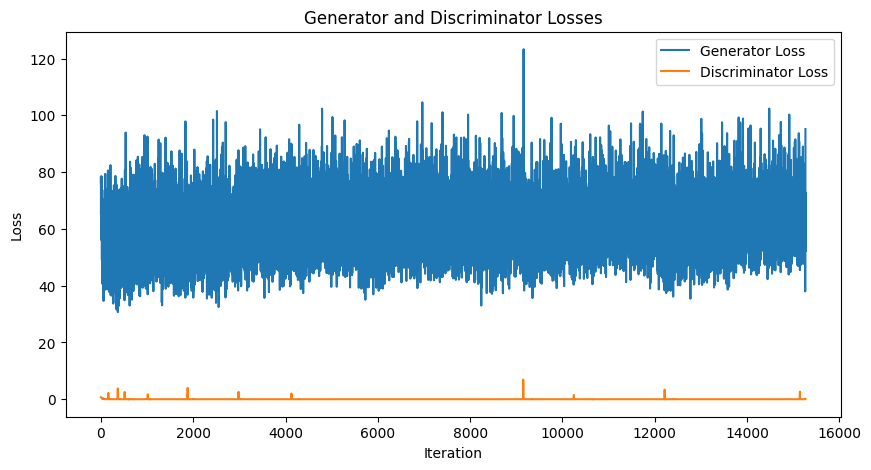

In [7]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Losses")
plt.show()

In [8]:
# Save models
torch.save(generator.state_dict(), "generator_sketch2clipart.pth")
torch.save(discriminator.state_dict(), "discriminator_sketch2clipart.pth")
print("Models saved to generator_sketch2clipart.pth and discriminator_sketch2clipart.pth")

Models saved to generator_sketch2clipart.pth and discriminator_sketch2clipart.pth


<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Sample Usage</h1>
</div>

In [11]:
# Redefine the model architectures
generator = UNetGenerator().to(device)
discriminator = PatchDiscriminator().to(device)

# Load weights
generator.load_state_dict(torch.load("generator_sketch2clipart.pth"))
discriminator.load_state_dict(torch.load("discriminator_sketch2clipart.pth"))

generator.eval()
discriminator.eval()

PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): Sigmoid()
  )
)

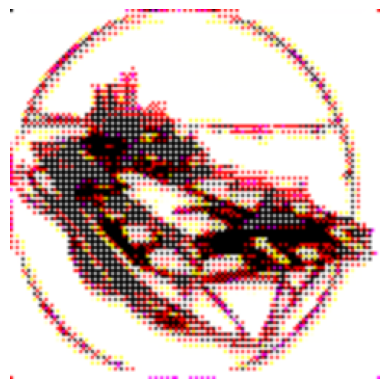

In [12]:
# Load a new sketch image
from PIL import Image
import torchvision.transforms as transforms

new_sketch = Image.open("data/sketch/sketch1.png").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
new_sketch_tensor = transform(new_sketch).unsqueeze(0).to(device)

# Generate clipart
with torch.no_grad():
    generated_clipart = generator(new_sketch_tensor)
    generated_clipart = nn.functional.interpolate(
        generated_clipart, size=(256, 256), mode='bilinear', align_corners=False
    )
    generated_clipart = (generated_clipart.squeeze().cpu() + 1) / 2  # Denormalize to [0, 1]

# Display
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.transpose(generated_clipart.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()